In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [4]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [16]:
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
param_grid = {
    'num_leaves': [20, 31, 40],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 10, 20],
    'min_data_in_leaf': [10, 20, 30],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq': [1, 5, 10]
}

In [20]:
def train_random_search(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        n_iter=20
    )

    random_search.fit(X, y)

    return random_search

In [26]:
def get_results(r_search):
    results = pd.DataFrame(r_search.cv_results_)

    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_num_leaves', 'param_learning_rate', 'param_n_estimators', 
            'param_max_depth', 'param_min_data_in_leaf', 'param_feature_fraction', 'param_bagging_fraction', 
            'param_bagging_freq', 'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
            'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 
            'mean_train_recall_macro', 'mean_test_recall_macro', 'rank_test_recall_macro', 
            'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results


In [27]:
pd.set_option('display.max_columns', None)

In [28]:
grid_search = train_random_search(X_train, y_train, lgb_model, param_grid)
results = get_results(grid_search)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 4898, number of 

In [29]:
results.head()

,mean_fit_time,mean_score_time,param_num_leaves,param_learning_rate,param_n_estimators,param_max_depth,param_min_data_in_leaf,param_feature_fraction,param_bagging_fraction,param_bagging_freq,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
4,126.244611,0.060355,40,0.10,1000,20,30,1.0,1.0,10,1.0,0.929769,1,1.0,0.931879,1,1.0,0.929770,1,1.0,0.929679,1
2,68.305387,0.043684,40,0.10,500,10,10,0.8,0.8,5,1.0,0.928748,3,1.0,0.930688,3,1.0,0.928748,3,1.0,0.928662,2
18,48.043125,0.255509,20,0.05,1000,10,10,0.6,0.8,5,1.0,0.928748,2,1.0,0.930901,2,1.0,0.928749,2,1.0,0.928656,3
10,130.733040,0.067333,40,0.10,1000,10,30,1.0,0.6,10,1.0,0.928646,4,1.0,0.930273,6,1.0,0.928647,4,1.0,0.928574,4
5,69.012617,0.060600,20,0.10,1000,20,30,0.8,0.8,5,1.0,0.928441,5,1.0,0.930205,7,1.0,0.928441,6,1.0,0.928363,5


In [33]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, search):
    results_df = pd.DataFrame(search.cv_results_)
    
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]
    
    if filter_top_n and "rank_test_f1_macro" in results_df.columns:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")
    
    param_cols = [col for col in results_df.columns if col.startswith('param_')]
    
    if not param_cols:
        print("Nenhuma coluna de parâmetro encontrada!")
        return
    
    plot_df = results_df.melt(
        id_vars=param_cols,
        value_vars=metrics,
        var_name="metric",
        value_name="score"
    )
    
    plt.figure(figsize=(12, 8))
    for (combo, group) in plot_df.groupby(param_cols, dropna=False):
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     label=label_str + " (train)")
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     label=label_str + " (test)")
    
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics - LightGBM (Balanced)")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

C:\Users\rafap\AppData\Local\Temp\ipykernel_20968\2323452608.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


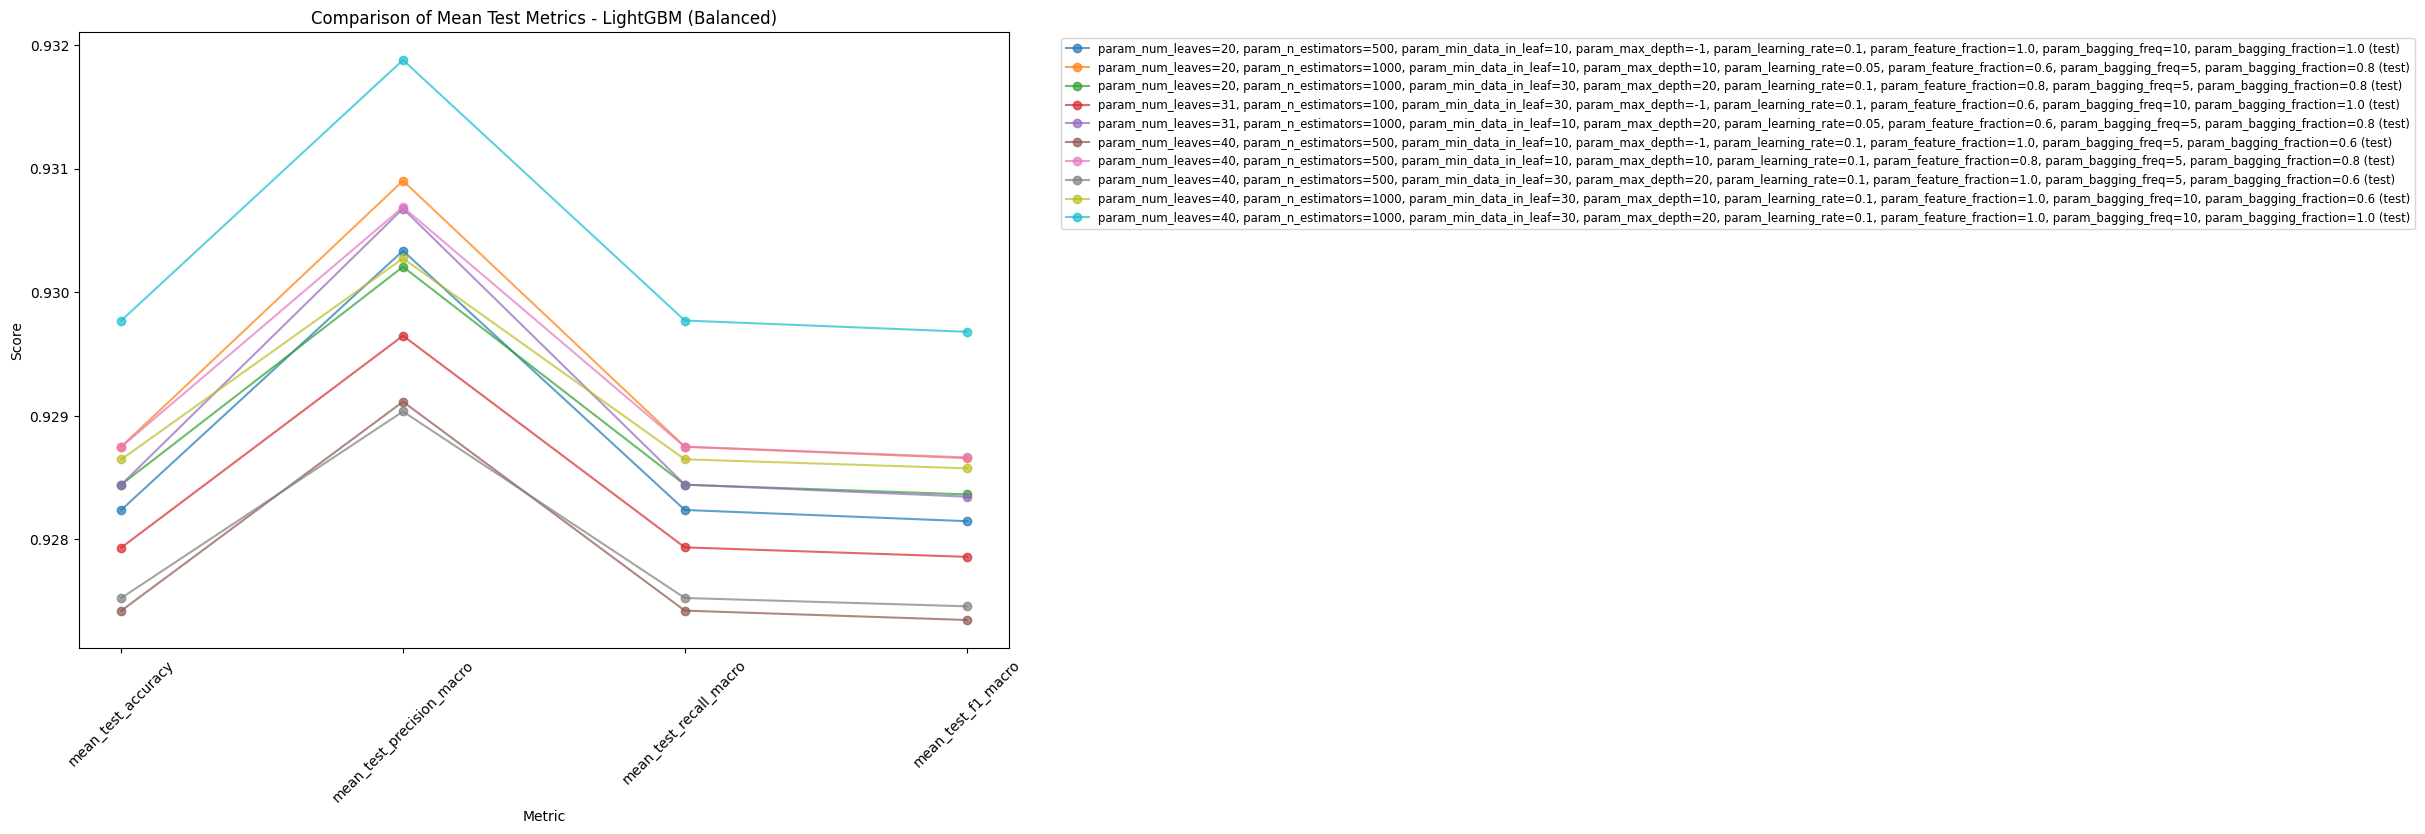

In [35]:
view_test_metrics(False, 10, grid_search)

In [ ]:
def os_smote(X, y):
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [37]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE para balanceamento
    ('lgbm', lgb.LGBMClassifier(random_state=42, class_weight='balanced')) 
])

In [ ]:
param_grid = [
    {
        'lgbm__num_leaves': [20, 31, 40],  
        'lgbm__learning_rate': [0.01, 0.05, 0.1],  
        'lgbm__n_estimators': [100, 300, 500], 
        'lgbm__max_depth': [-1, 10, 20], 
        'lgbm__min_data_in_leaf': [10, 20, 30],  
        'lgbm__feature_fraction': [0.6, 0.8, 1.0],  
        'lgbm__bagging_fraction': [0.6, 0.8, 1.0], 
        'lgbm__bagging_freq': [1, 5, 10], 
    }
]

In [39]:
def get_results_pipeline(g_search):
    results = pd.DataFrame(g_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_lgbm__num_leaves', 'param_lgbm__learning_rate', 
            'param_lgbm__n_estimators', 'param_lgbm__max_depth', 'param_lgbm__min_data_in_leaf', 
            'param_lgbm__feature_fraction', 'param_lgbm__bagging_fraction', 'param_lgbm__bagging_freq',
            'mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 'mean_train_precision_macro', 
            'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [ ]:
def view_test_metrics_pipeline(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        "param_lgbm__num_leaves", "param_lgbm__learning_rate", "param_lgbm__n_estimators", 
        "param_lgbm__max_depth", "param_lgbm__min_data_in_leaf", "param_lgbm__feature_fraction", 
        "param_lgbm__bagging_fraction", "param_lgbm__bagging_freq"
    ]

    plot_df = results_df.melt(
        id_vars=param_cols,     
        value_vars=metrics,      
        var_name="metric",       
        value_name="score"       
    )

    plt.figure(figsize=(12, 8))

    groups = list(plot_df.groupby(param_cols))
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        color = colors[i]

        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]

        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")

        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [41]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 4898, number of nega

In [42]:
results.head()

,mean_fit_time,mean_score_time,param_lgbm__num_leaves,param_lgbm__learning_rate,param_lgbm__n_estimators,param_lgbm__max_depth,param_lgbm__min_data_in_leaf,param_lgbm__feature_fraction,param_lgbm__bagging_fraction,param_lgbm__bagging_freq,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
17,57.949838,0.054232,40,0.10,500,20,30,1.0,0.8,5,1.000000,0.930278,1,1.000000,0.932386,1,1.000000,0.930278,1,1.000000,0.930188,1
16,25.987423,0.043842,31,0.05,300,-1,30,0.6,0.6,5,0.998208,0.929871,2,0.998213,0.931483,3,0.998208,0.929873,2,0.998208,0.929803,2
18,53.725954,0.051247,40,0.10,500,-1,10,0.8,1.0,1,1.000000,0.929360,3,1.000000,0.931855,2,1.000000,0.929360,3,1.000000,0.929254,3
15,59.408592,0.052240,40,0.05,500,20,10,0.8,0.8,5,1.000000,0.928646,4,1.000000,0.930726,4,1.000000,0.928648,4,1.000000,0.928556,4
4,34.050465,0.042970,40,0.10,300,20,10,1.0,1.0,10,1.000000,0.928338,5,1.000000,0.930457,5,1.000000,0.928338,5,1.000000,0.928246,5


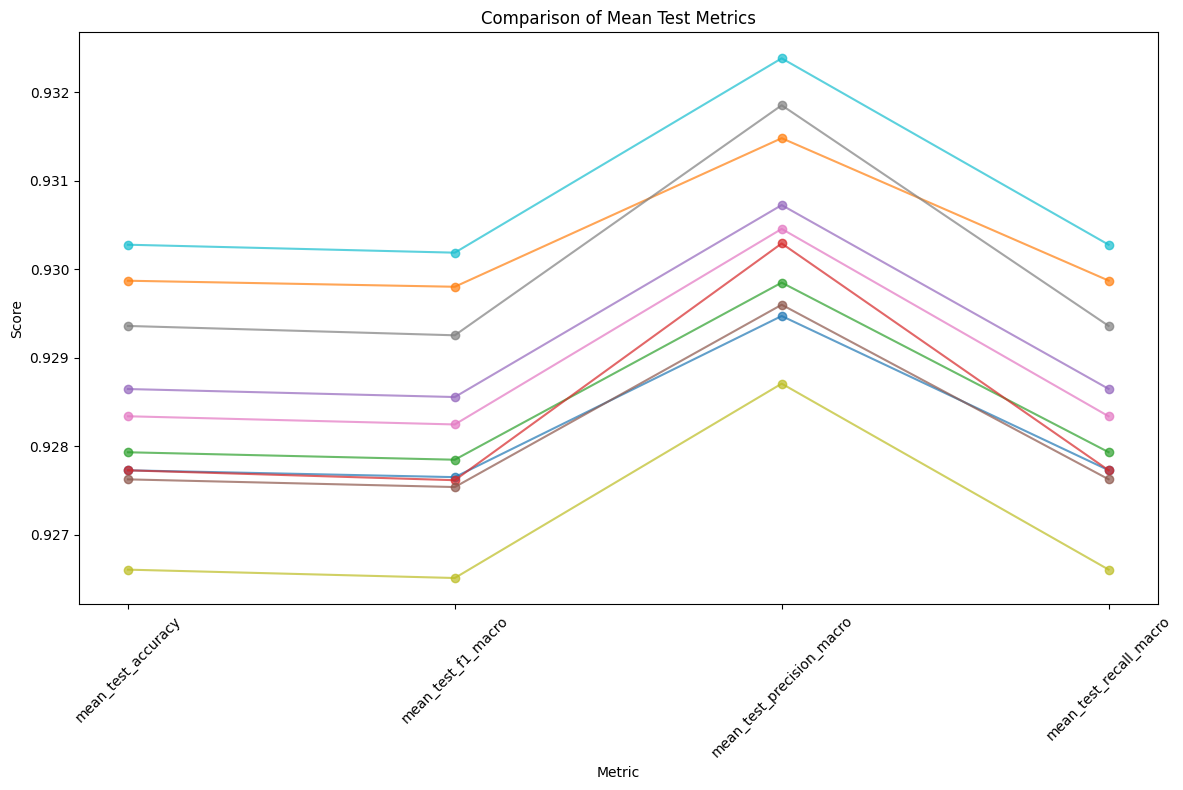

In [43]:
view_test_metrics_pipeline(False, 10, results)

In [44]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, class_weight='balanced'))  # Usando LGBMClassifier
])

In [45]:
grid_search = train_random_search(X_train, y_train, pipeline, param_grid)
results = get_results_pipeline(grid_search)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 4898, number of nega

In [46]:
results.head()

,mean_fit_time,mean_score_time,param_lgbm__num_leaves,param_lgbm__learning_rate,param_lgbm__n_estimators,param_lgbm__max_depth,param_lgbm__min_data_in_leaf,param_lgbm__feature_fraction,param_lgbm__bagging_fraction,param_lgbm__bagging_freq,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
7,54.906704,0.060669,40,0.05,500,-1,30,0.6,0.8,5,1.000000,0.929462,1,1.000000,0.931434,1,1.000000,0.929463,1,1.000000,0.929378,1
0,55.152027,0.062199,40,0.05,500,-1,10,0.6,0.8,10,1.000000,0.929258,2,1.000000,0.931386,2,1.000000,0.929259,2,1.000000,0.929168,2
15,12.199867,0.035062,40,0.10,100,20,30,0.6,1.0,1,0.995792,0.929054,3,0.995821,0.930696,3,0.995792,0.929055,3,0.995792,0.928983,3
6,54.307879,0.053438,40,0.10,500,10,10,1.0,0.6,1,1.000000,0.928236,4,1.000000,0.930029,4,1.000000,0.928237,4,1.000000,0.928159,4
17,31.472955,0.045605,20,0.10,500,-1,20,1.0,1.0,10,1.000000,0.928034,5,1.000000,0.929826,5,1.000000,0.928034,5,1.000000,0.927955,5


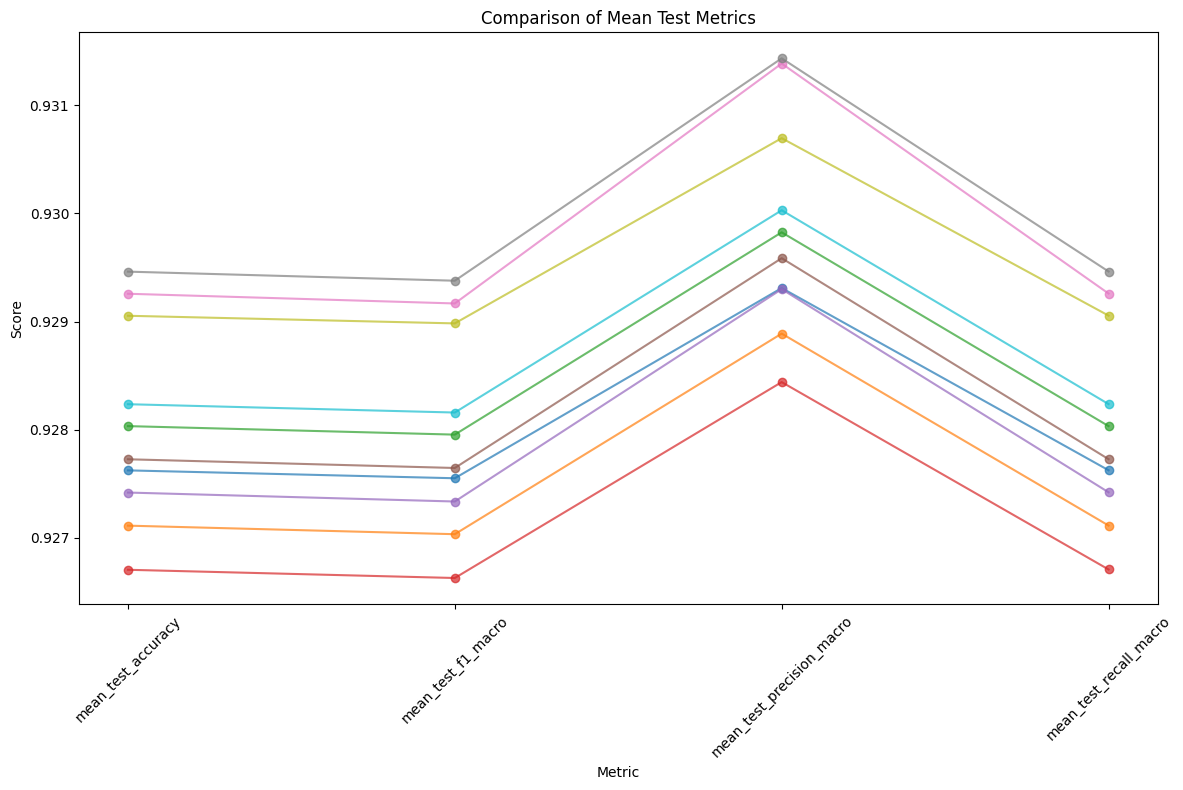

In [47]:
view_test_metrics_pipeline(False, 10, results)

In [ ]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),  # Balanceamento
    ('lgbm', lgb.LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=100,
        num_leaves=31,  
        learning_rate=0.1  
    ))
])

In [49]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

In [50]:
cm = confusion_matrix(y_train, preds)

[LightGBM] [Info] Number of positive: 4898, number of negative: 4898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31323
[LightGBM] [Info] Number of data points in the train set: 9796, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


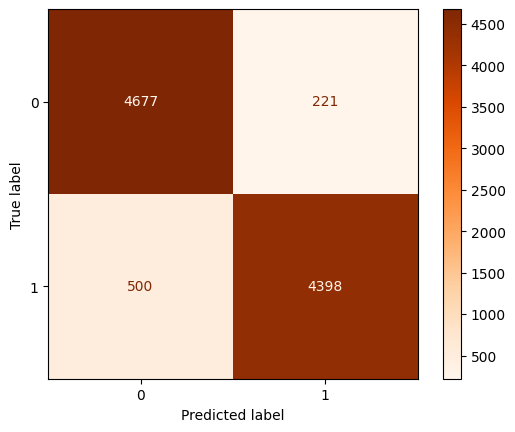

In [ ]:
# ajuste do pipeline antes de acessar as classes
pipeline.fit(X_train, y_train)

cmd = ConfusionMatrixDisplay(cm, display_labels=pipeline.named_steps['lgbm'].classes_)

cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [53]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9034    0.9549    0.9284      4898
           1     0.9522    0.8979    0.9242      4898

    accuracy                         0.9264      9796
   macro avg     0.9278    0.9264    0.9263      9796
weighted avg     0.9278    0.9264    0.9263      9796



In [54]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 4898, number of negative: 4898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31323
[LightGBM] [Info] Number of data points in the train set: 9796, number of used features: 129
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('oversampler', RandomOverSampler(random_state=42)),
                ('lgbm',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [58]:
lgbm = pipeline.named_steps['lgbm']

In [60]:
col_names = list(joblib.load('data/col_names.pkl'))

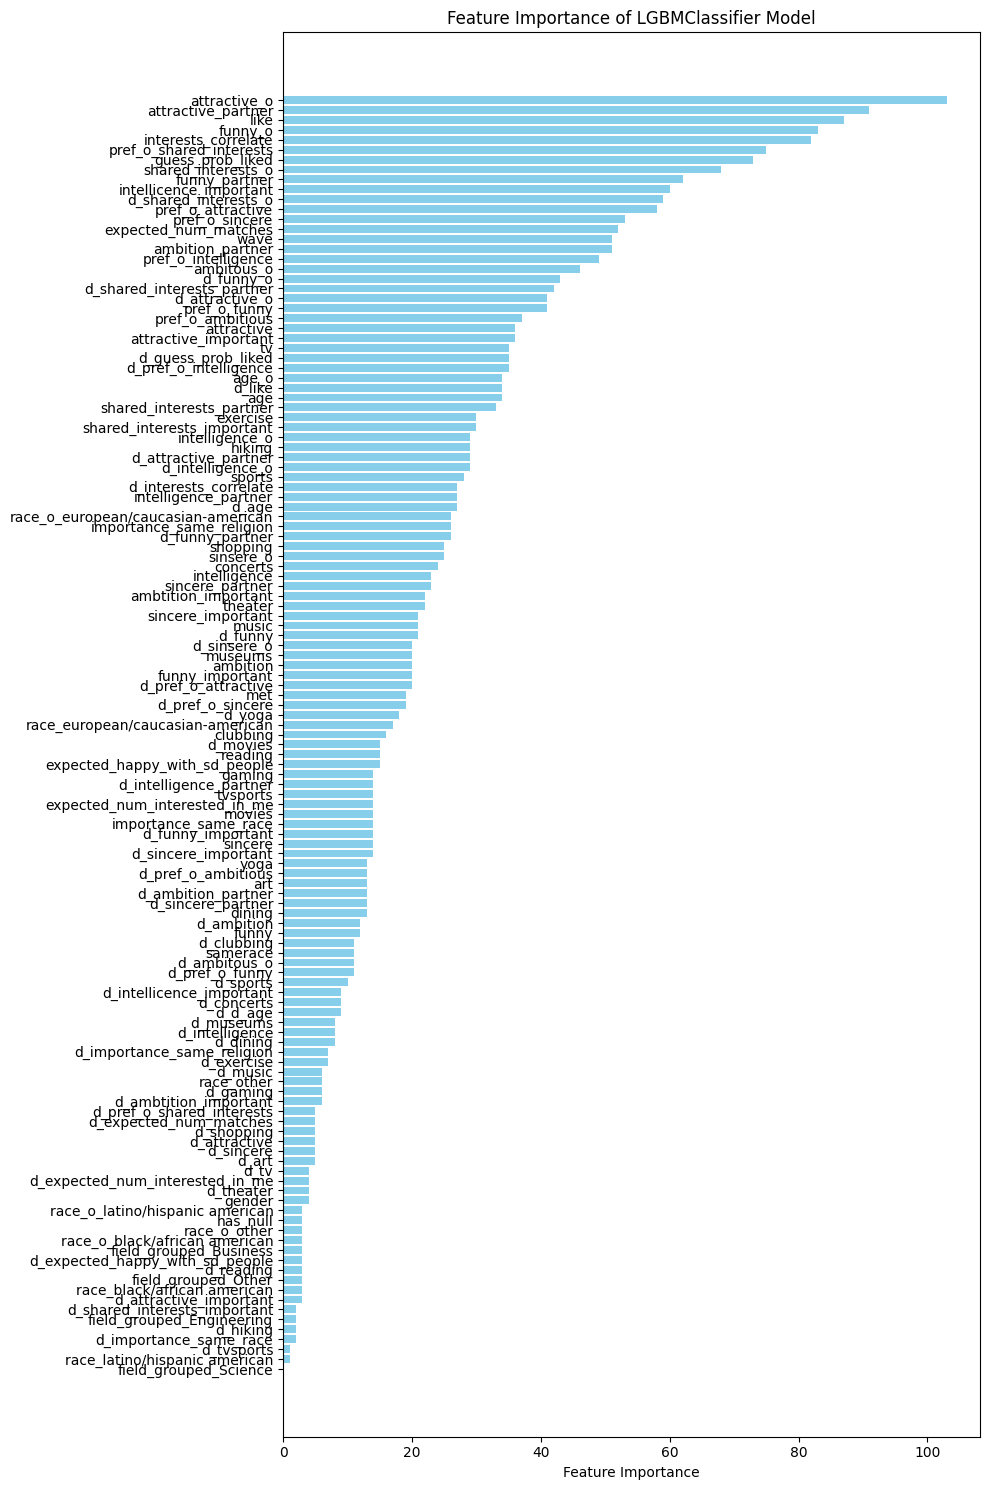

In [61]:
importances = lgbm.feature_importances_.ravel().reshape(1, -1)

feature_importance = pd.DataFrame(data=importances, columns=col_names)

importance_series = feature_importance.iloc[0]
importance_series_sorted = importance_series.sort_values(ascending=True)

plt.figure(figsize=(10, 15))
plt.barh(importance_series_sorted.index, importance_series_sorted.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of LGBMClassifier Model')
plt.tight_layout()
plt.show()

In [57]:
joblib.dump(pipeline.named_steps['lgbm'], 'models/lightgbm.pkl')

['models/lightgbm.pkl']